
# EDA · Saber 11 (2020) — Nariño y Pasto · **TFM Data Science**

Este cuaderno desarrolla un **Análisis Exploratorio de Datos (EDA)** profesional sobre la cohorte **Saber 11 – 2016**, con foco en **Nariño** (y corte específico **Pasto**).  
El EDA está **alineado a los objetivos del TFM**: construir una base confiable de entrada para estimar, más adelante, el **Valor Agregado (VA)** y la **Contribución Relativa (CR)** del programa **Ingeniería de Sistemas – Universidad Mariana** al comparar **Saber 11 (entrada)** vs **Saber Pro (salida)**.

### Qué persigue este EDA
- **Calidad de datos**: unificar 2020_1 + 2020_2, limpiar tipos, normalizar textos, validar rangos y duplicados.
- **Caracterización de entrada** (baseline): puntajes globales y por áreas en Nariño / Pasto.
- **Contexto sociodemográfico**: género, estrato, naturaleza del colegio y jornada.
- **Estructuras agregadas** listas para VA/CR**: resúmenes por colegio y municipio exportados como insumo para el modelado.
- **Gráficas explicativas**: cada figura responde a una pregunta de negocio del TFM (ver notas bajo cada gráfico).

> **Nota**: Este cuaderno **no** calcula VA ni CR. Deja listos los **features** de entrada (Saber 11) que luego se cruzarán con **Saber Pro** por cohorte.


In [1]:

import os
import unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    "figure.figsize": (9, 5),
    "axes.grid": True
})

print("Libs OK")

Libs OK



## 1) Lectura y unión de fuentes

Archivos oficiales ICFES (TXT `;`) de **2020**: primer y segundo semestre.  
**Edite las rutas si cambian los nombres.**


In [2]:

FILE_1S = "Examen_Saber_11_20201.txt"
FILE_2S = "Examen_Saber_11_20202.txt"

# Columnas de interés (tolerante: si falta alguna, el lector no falla)
COLS = [
    # Ubicación y colegio
    "cole_cod_depto_ubicacion","cole_cod_mcpio_ubicacion",
    "cole_depto_ubicacion","cole_mcpio_ubicacion",
    "cole_nombre_establecimiento","cole_naturaleza","cole_area_ubicacion","cole_jornada","cole_genero",
    # Estudiante / familia
    "estu_genero","estu_inse_individual","fami_estratovivienda",
    # Puntajes
    "punt_global","punt_matematicas","punt_lectura_critica",
    "punt_sociales_ciudadanas","punt_c_naturales","punt_ingles",
    # Meta
    "periodo"
]

def safe_read(path, cols):
    if not os.path.exists(path):
        print(f"⚠️ No se encontró: {path}")
        return pd.DataFrame(columns=cols)
    df = pd.read_csv(path, sep=";", encoding="latin1", low_memory=False)
    keep = [c for c in cols if c in df.columns]
    return df[keep].copy()

df1 = safe_read(FILE_1S, COLS)
df2 = safe_read(FILE_2S, COLS)
df = pd.concat([df1, df2], ignore_index=True)
print("Dimensiones combinadas:", df.shape)
df.head(3)

Dimensiones combinadas: (603112, 19)


,cole_cod_depto_ubicacion,cole_cod_mcpio_ubicacion,cole_depto_ubicacion,cole_mcpio_ubicacion,cole_nombre_establecimiento,cole_naturaleza,cole_area_ubicacion,cole_jornada,cole_genero,estu_genero,estu_inse_individual,fami_estratovivienda,punt_global,punt_matematicas,punt_lectura_critica,punt_sociales_ciudadanas,punt_c_naturales,punt_ingles,periodo
0,5.0,5607.0,ANTIOQUIA,RETIRO,COLEGIO GIMNASIO VERMONT,NO OFICIAL,RURAL,COMPLETA,MIXTO,M,84.836365,Estrato 6,387,73,79,77,73,100.0,20201
1,76.0,76001.0,VALLE,CALI,LICEO CARLOS CASTRO SAAVEDRA,NO OFICIAL,URBANO,TARDE,MIXTO,F,54.801414,Estrato 3,254,51,54,44,54,51.0,20201
2,25.0,25754.0,CUNDINAMARCA,SOACHA,INSTITUTO BOLIVARIANO ESDISEÃOS,NO OFICIAL,URBANO,MAÃANA,MIXTO,F,71.796471,NaN,245,42,63,53,39,47.0,20201



## 2) Limpieza / Normalización

- Tipos numéricos para puntajes y códigos de ubicación.  
- Normalización robusta de textos (quita tildes/espacios no rompibles, mayúsculas).  
- Eliminación de duplicados.


In [3]:

# 2.1 Puntajes a numéricos
punt_cols = ["punt_global","punt_matematicas","punt_lectura_critica",
             "punt_sociales_ciudadanas","punt_c_naturales","punt_ingles"]
for c in punt_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# 2.2 Códigos a enteros (si existen)
for c in ["cole_cod_depto_ubicacion","cole_cod_mcpio_ubicacion"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int64")

# 2.3 Normalizador de texto
def norm_text(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.replace("\xa0"," ", regex=False).str.strip()
    s = s.apply(lambda x: "".join(ch for ch in unicodedata.normalize("NFKD", x) if not unicodedata.combining(ch)))
    return s.str.upper()

for c in ["cole_depto_ubicacion","cole_mcpio_ubicacion","cole_nombre_establecimiento","cole_naturaleza",
          "cole_area_ubicacion","cole_jornada","cole_genero","estu_genero","fami_estratovivienda"]:
    if c in df.columns:
        df[c] = norm_text(df[c])

# 2.4 Duplicados
before = len(df)
df = df.drop_duplicates()
print("Duplicados eliminados:", before - len(df))

df.info()

Duplicados eliminados: 107
<class 'pandas.core.frame.DataFrame'>
Index: 603005 entries, 0 to 603111
Data columns (total 19 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   cole_cod_depto_ubicacion     529574 non-null  Int64  
 1   cole_cod_mcpio_ubicacion     529574 non-null  Int64  
 2   cole_depto_ubicacion         603005 non-null  object 
 3   cole_mcpio_ubicacion         603005 non-null  object 
 4   cole_nombre_establecimiento  603005 non-null  object 
 5   cole_naturaleza              603005 non-null  object 
 6   cole_area_ubicacion          603005 non-null  object 
 7   cole_jornada                 603005 non-null  object 
 8   cole_genero                  603005 non-null  object 
 9   estu_genero                  603005 non-null  object 
 10  estu_inse_individual         514937 non-null  float64
 11  fami_estratovivienda         603005 non-null  object 
 12  punt_global                  603005 


## 3) Enfoque regional: **Nariño** y **Pasto**

Se aplican filtros por **código** y, como respaldo, por **texto normalizado**.


In [4]:

mask_narino = (
    (("cole_cod_depto_ubicacion" in df.columns) & (df["cole_cod_depto_ubicacion"] == 52))
    | (("cole_depto_ubicacion" in df.columns) & (df["cole_depto_ubicacion"] == "NARINO"))
)

mask_pasto = mask_narino & (
    (("cole_cod_mcpio_ubicacion" in df.columns) & (df["cole_cod_mcpio_ubicacion"] == 52001))
    | (("cole_mcpio_ubicacion" in df.columns) & (df["cole_mcpio_ubicacion"] == "PASTO"))
)

df_narino = df[mask_narino].copy()
df_pasto  = df[mask_pasto].copy()

print("Nariño:", df_narino.shape, " | Pasto:", df_pasto.shape)
display(df_narino.head(3))

Nariño: (16390, 19)  | Pasto: (5073, 19)


,cole_cod_depto_ubicacion,cole_cod_mcpio_ubicacion,cole_depto_ubicacion,cole_mcpio_ubicacion,cole_nombre_establecimiento,cole_naturaleza,cole_area_ubicacion,cole_jornada,cole_genero,estu_genero,estu_inse_individual,fami_estratovivienda,punt_global,punt_matematicas,punt_lectura_critica,punt_sociales_ciudadanas,punt_c_naturales,punt_ingles,periodo
79,52,52001,NARIAO,PASTO,COL COMFAMILIAR DE NARIAO SIGLO XXI,NO OFICIAL,URBANO,MAAANA,MIXTO,M,52.588058,NAN,243,55,52,38,47,55.0,20201
100,52,52001,NARIAO,PASTO,COL INSUCA,NO OFICIAL,URBANO,MAAANA,MIXTO,M,63.150906,ESTRATO 3,299,57,67,66,54,46.0,20201
263,52,52001,NARIAO,PASTO,COL INSUCA,NO OFICIAL,URBANO,MAAANA,MIXTO,M,45.425953,ESTRATO 2,357,79,67,68,73,66.0,20201



## 4) Chequeos de calidad

Sanity checks mínimos para garantizar confiabilidad del baseline:
- Porcentaje de nulos en puntajes.
- Rango plausible de puntajes (0–500 aprox.).


In [5]:

# 4.1 Nulos en puntajes (Nariño)
nulls = df_narino[punt_cols].isna().mean().sort_values(ascending=False).to_frame("pct_null")
print("Porcentaje de nulos (Nariño):")
display((nulls*100).round(2))

# 4.2 Rango plausible
rmin = df_narino[punt_cols].min()
rmax = df_narino[punt_cols].max()
rng = pd.DataFrame({"min": rmin, "max": rmax})
print("Rango de puntajes observado (Nariño):")
display(rng)

Porcentaje de nulos (Nariño):


,pct_null
punt_ingles,0.86
punt_global,0.00
punt_matematicas,0.00
punt_lectura_critica,0.00
punt_sociales_ciudadanas,0.00
punt_c_naturales,0.00


Rango de puntajes observado (Nariño):


,min,max
punt_global,0.0,458.0
punt_matematicas,0.0,100.0
punt_lectura_critica,0.0,100.0
punt_sociales_ciudadanas,0.0,100.0
punt_c_naturales,0.0,100.0
punt_ingles,0.0,100.0



## 5) Descriptivos estadísticos (baseline de entrada)

Medidas de tendencia central y dispersión en **Nariño** y **Pasto**.


In [6]:

desc_narino = df_narino[punt_cols].describe().T
desc_pasto  = df_pasto[punt_cols].describe().T

print("Descriptivos — Nariño")
display(desc_narino)
print("Descriptivos — Pasto")
display(desc_pasto)

Descriptivos — Nariño


,count,mean,std,min,25%,50%,75%,max
punt_global,16390.0,248.562782,48.855380,0.0,212.0,247.0,283.0,458.0
punt_matematicas,16390.0,51.319402,11.881287,0.0,43.0,52.0,60.0,100.0
punt_lectura_critica,16390.0,51.820134,10.161499,0.0,44.0,52.0,59.0,100.0
punt_sociales_ciudadanas,16390.0,47.881696,11.715461,0.0,39.0,47.0,57.0,100.0
punt_c_naturales,16390.0,49.011287,10.631672,0.0,41.0,49.0,57.0,100.0
punt_ingles,16249.0,46.183827,10.450547,0.0,39.0,45.0,52.0,100.0


Descriptivos — Pasto


,count,mean,std,min,25%,50%,75%,max
punt_global,5073.0,268.181549,46.888055,0.0,234.0,268.0,300.0,458.0
punt_matematicas,5073.0,55.234772,11.256188,0.0,48.0,56.0,63.0,100.0
punt_lectura_critica,5073.0,55.485314,9.500033,0.0,49.0,56.0,62.0,100.0
punt_sociales_ciudadanas,5073.0,52.110585,11.557913,0.0,44.0,52.0,60.0,100.0
punt_c_naturales,5073.0,52.814311,10.354588,0.0,45.0,53.0,60.0,100.0
punt_ingles,5026.0,50.371667,11.232644,0.0,43.0,49.0,56.0,100.0



## 6) Perfil sociodemográfico (para análisis causal posterior)

Estas distribuciones explican **heterogeneidad de entrada**. Serán controles en modelos de VA/CR (evitan sesgos por composición):
- **Género** (`estu_genero`)
- **Estrato** (`fami_estratovivienda`)
- **Naturaleza del colegio** (`cole_naturaleza`)
- **Jornada** (`cole_jornada`)


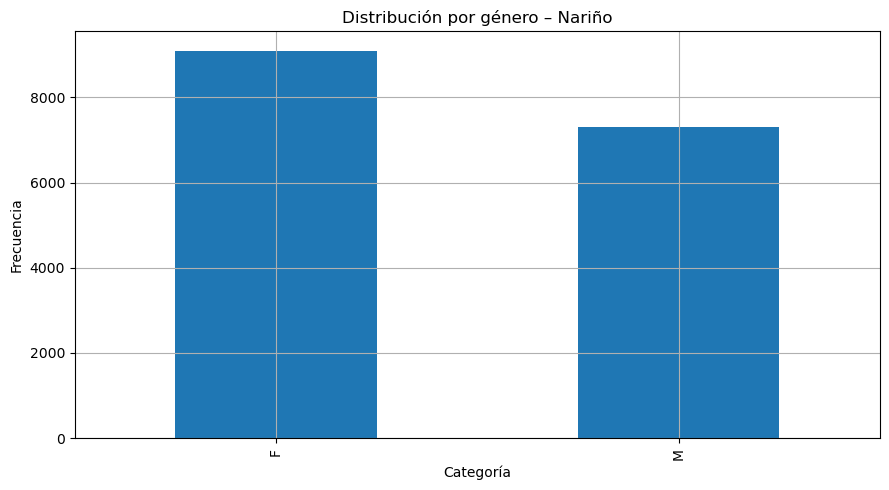

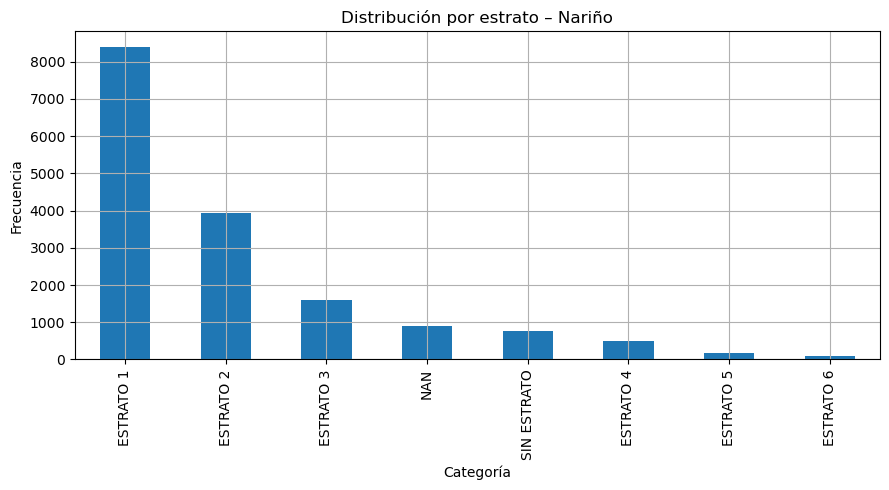

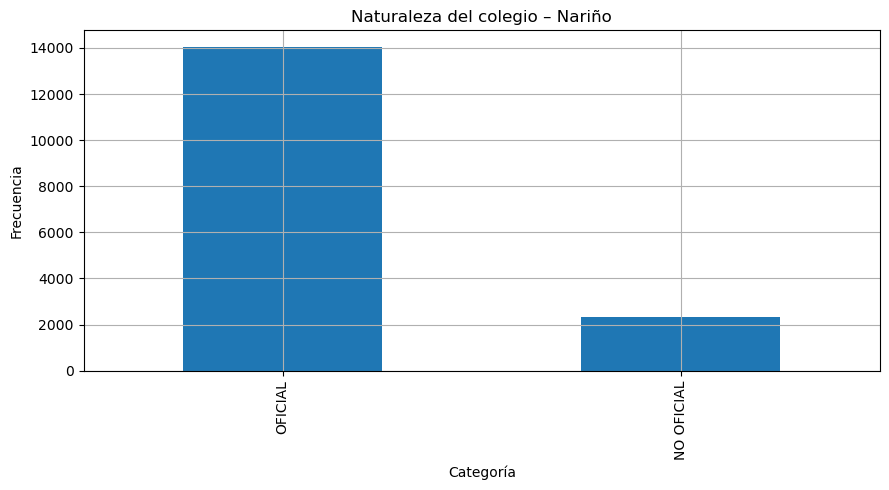

C:\Users\sebas\AppData\Local\Temp\ipykernel_12604\1283191449.py:8: UserWarning: Glyph 145 (\x91) missing from current font.
  plt.tight_layout()
c:\Users\sebas\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 145 (\x91) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


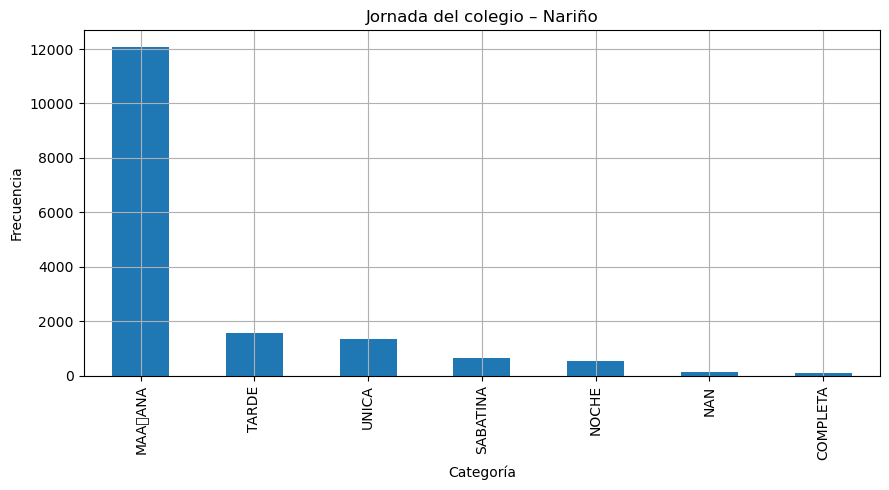

In [7]:

def bar_count(series, title):
    vc = series.value_counts(dropna=False)
    plt.figure()
    vc.plot(kind="bar")
    plt.title(title)
    plt.xlabel("Categoría")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

if "estu_genero" in df_narino.columns:
    bar_count(df_narino["estu_genero"], "Distribución por género – Nariño")

if "fami_estratovivienda" in df_narino.columns:
    bar_count(df_narino["fami_estratovivienda"], "Distribución por estrato – Nariño")

if "cole_naturaleza" in df_narino.columns:
    bar_count(df_narino["cole_naturaleza"], "Naturaleza del colegio – Nariño")

if "cole_jornada" in df_narino.columns:
    bar_count(df_narino["cole_jornada"], "Jornada del colegio – Nariño")

1. Distribución por género – Nariño

En 2020 persiste la predominancia femenina, con aproximadamente 9.000 mujeres frente a 7.200 hombres. Esta brecha de género, estable en el tiempo, continúa siendo relevante para el cálculo del Valor Agregado (VA) y la Contribución Relativa (CR), pues las diferencias de composición pueden influir en los resultados globales si no se ajustan adecuadamente.

2. Distribución por estrato – Nariño

El estrato 1 concentra la mayor parte de los estudiantes (≈8.300), seguido por estrato 2 (≈4.000) y una proporción mucho menor en los estratos 3 y 4. Los estratos altos (5 y 6) son residuales. Esta estructura refuerza el carácter vulnerable del departamento y la necesidad de incluir esta variable como control en el modelado para evitar atribuir diferencias estructurales a los efectos institucionales.

3. Naturaleza del colegio – Nariño

La mayoría proviene de instituciones oficiales, con una proporción cercana a 6:1 frente a no oficiales. Este patrón constante muestra la dependencia del sistema público y su impacto en los niveles de desempeño de entrada a la educación superior.

4. Jornada del colegio – Nariño

La jornada de la mañana sigue siendo predominante (más de 12.000 estudiantes), con representación menor de modalidades como tarde, única, sabatina y noche. Esta homogeneidad implica que la jornada no explica gran parte de la variación en el rendimiento, pero contribuye a caracterizar la organización del sistema educativo.


**Uso en el TFM:** estas variables se incorporarán como **controles** al estimar el desempeño esperado en Saber Pro condicional a las características de entrada (baseline), permitiendo aislar el **efecto agregado** atribuible a la formación universitaria.



## 7) Distribución de puntajes (Nariño vs Pasto)

Las curvas y boxplots permiten visualizar **nivel y dispersión** de entrada por territorio.


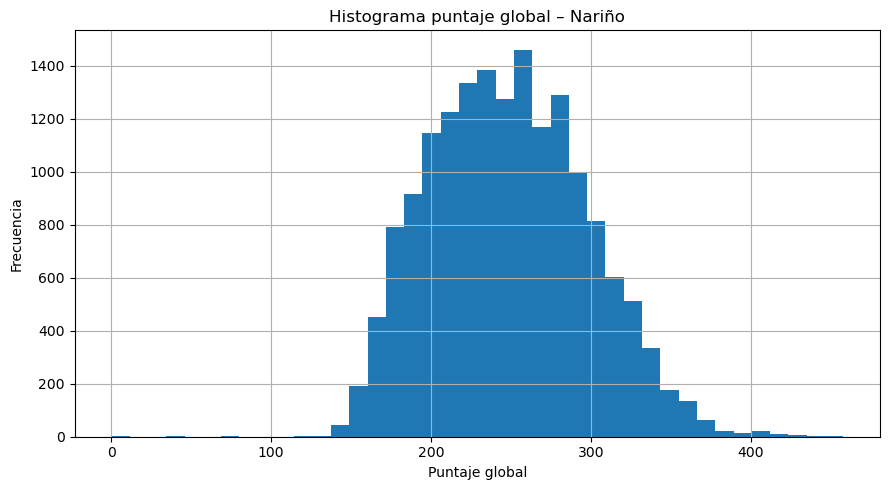

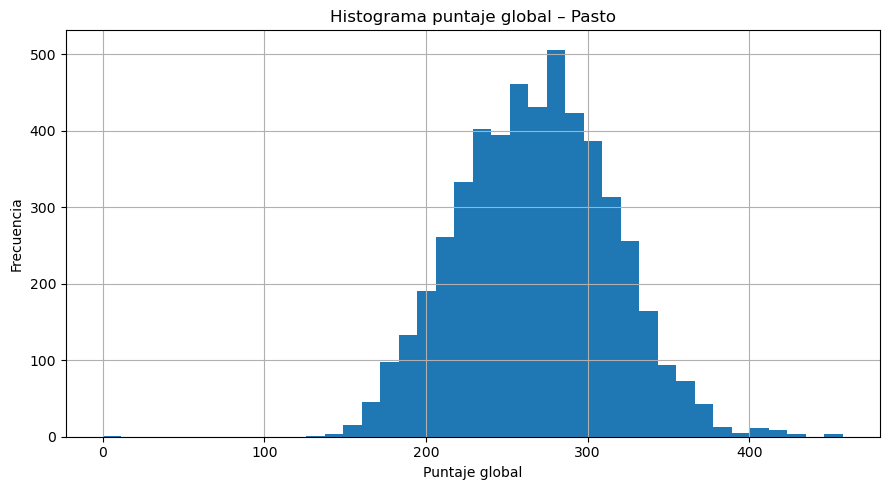

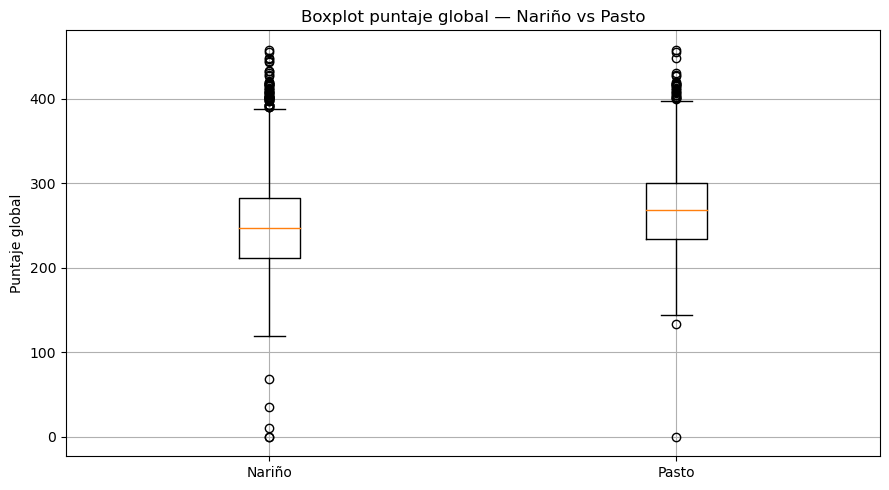

In [8]:

def hist_one(series, title, xlabel):
    if series.notna().any():
        plt.figure()
        series.dropna().plot(kind="hist", bins=40)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel("Frecuencia")
        plt.tight_layout()
        plt.show()

# Hist global
hist_one(df_narino["punt_global"], "Histograma puntaje global – Nariño", "Puntaje global")
hist_one(df_pasto["punt_global"],  "Histograma puntaje global – Pasto",  "Puntaje global")

# Boxplot comparativo
vals, labels = [], []
if df_narino["punt_global"].notna().any():
    vals.append(df_narino["punt_global"].dropna()); labels.append("Nariño")
if df_pasto["punt_global"].notna().any():
    vals.append(df_pasto["punt_global"].dropna());  labels.append("Pasto")

if vals:
    plt.figure()
    plt.boxplot(vals, labels=labels, vert=True)
    plt.title("Boxplot puntaje global — Nariño vs Pasto")
    plt.ylabel("Puntaje global")
    plt.tight_layout()
    plt.show()

5. Histograma de puntaje global – Nariño

La distribución de puntajes globales se aproxima a la normal, concentrándose entre 200 y 300 puntos, con un promedio cercano a los 250 puntos. La dispersión moderada confirma la estabilidad del rendimiento departamental, con presencia de casos extremos en ambos extremos de la distribución.

6. Histograma de puntaje global – Pasto

En Pasto, los puntajes se concentran en un rango superior (≈240–310 puntos), con una media cercana a los 270 puntos, mayor que la departamental. Esto confirma la ventaja de los estudiantes urbanos y subraya la necesidad de ajustar los modelos de VA y CR por contexto geográfico.

7. Boxplot puntaje global — Nariño vs Pasto

El boxplot evidencia una mediana superior en Pasto respecto a Nariño, así como menor dispersión en los puntajes urbanos. La presencia de outliers, tanto altos como bajos, refleja la heterogeneidad de la población, pero no altera la conclusión central: los estudiantes de la capital parten de un nivel inicial más alto.


**Uso en el TFM:** estas figuras justifican los **ajustes de baseline** por territorio (municipio) cuando se calcule VA/CR, y permiten reportar si Pasto difiere sistemáticamente del resto del departamento.



## 8) Comparación por áreas (medias)

Promedios por competencia para Nariño vs Pasto. Útil para identificar **áreas deficitarias** de entrada.


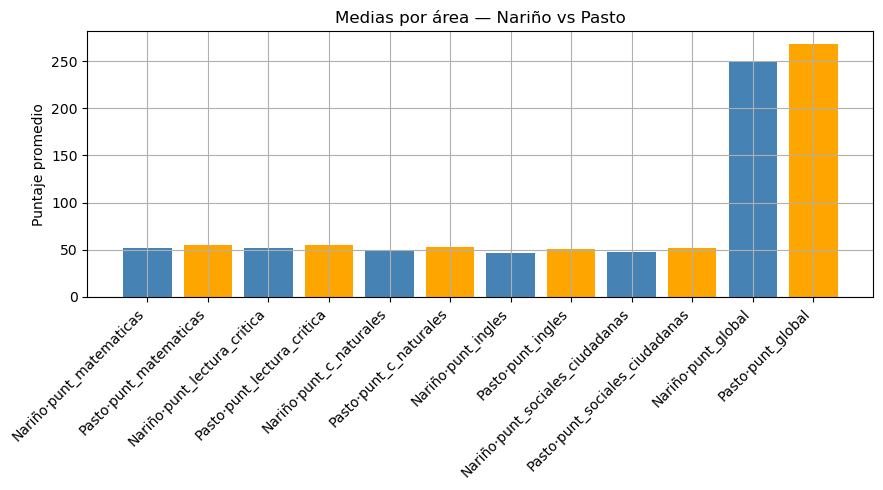

In [9]:
areas = ["punt_matematicas","punt_lectura_critica","punt_c_naturales",
         "punt_ingles","punt_sociales_ciudadanas","punt_global"]

means = []
labels = []
colors = []

for a in areas:
    if a in df_narino.columns:
        means.append(df_narino[a].mean())
        labels.append(f"Nariño·{a}")
        colors.append("steelblue")   # color para Nariño
    if a in df_pasto.columns:
        means.append(df_pasto[a].mean())
        labels.append(f"Pasto·{a}")
        colors.append("orange")      # color para Pasto

plt.figure()
plt.bar(labels, means, color=colors)
plt.title("Medias por área — Nariño vs Pasto")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Puntaje promedio")
plt.tight_layout()
plt.show()


8. Medias por área — Nariño vs Pasto

En todas las áreas evaluadas (matemáticas, lectura crítica, ciencias naturales, inglés y sociales ciudadanas), Pasto supera ligeramente a Nariño. Las diferencias más marcadas aparecen en matemáticas e inglés, lo que sugiere competencias críticas donde la brecha es más visible y donde el valor agregado universitario puede ser más claramente evidenciado.


**Uso en el TFM:** orienta hipótesis de **valor agregado diferencial por competencias** (p. ej., si el baseline en matemáticas es bajo, esperar mayor VA si la universidad fortalece esta área).



## 9) Ranking de colegios (Pasto)

Se listan los **Top-10** por puntaje global promedio.  
Esto sirve para construir *perfiles de ingreso* por colegio en la futura plataforma web.


In [10]:

ranking_pasto = pd.DataFrame()
if {"cole_nombre_establecimiento","punt_global"}.issubset(df_pasto.columns):
    ranking_pasto = (df_pasto
                     .groupby("cole_nombre_establecimiento", as_index=False)["punt_global"]
                     .mean()
                     .sort_values("punt_global", ascending=False)
                     .head(10))
    display(ranking_pasto)
else:
    print("No hay columnas suficientes para el ranking.")

,cole_nombre_establecimiento,punt_global
71,LIC INTEGD DE BTO UNIVERSIDAD DE NARIAO,335.913793
13,COL SAN FRANCISCO JAVIER,329.840909
16,COLEGIO DEL SAGRADO CORAZON DE JESUS,327.734375
58,INST CHAMPAGNAT,316.507143
5,COL FILIPENSE NUESTRA SRA DE LA ESPERANZA,305.518072
7,COL LA INMACULADA,301.920000
27,I.E.M. CIUDAD DE PASTO,293.540166
3,COL COMFAMILIAR DE NARIAO SIGLO XXI,292.923077
12,COL SAN FELIPE NERI,290.455446
73,LICEO DE LA MERCED MARIDIAZ,290.090909



## 10) Exportación — **Features de entrada** para VA/CR

Se exportan datasets **limpios** y agregados que el pipeline utilizará al cruzar con Saber Pro:
- `s11_2020_muni_summary.csv` → promedio por municipio (Nariño).


In [11]:
from pathlib import Path
import pandas as pd

# Usa una ruta corta/sencilla (cámbiala si quieres)
out_dir = Path(r"C:\Temp\s11_2017_tfm_outputs")
out_dir.mkdir(parents=True, exist_ok=True)

punt_cols = ["punt_global","punt_matematicas","punt_lectura_critica",
             "punt_sociales_ciudadanas","punt_c_naturales","punt_ingles"]

muni_summary = df_narino

out_file = out_dir / "s11_2020_muni_summary.csv"
muni_summary.to_csv(str(out_file), index=False, encoding="utf-8-sig")  # <-- str(...)
print("✅ Guardado:", out_file)


✅ Guardado: C:\Temp\s11_2017_tfm_outputs\s11_2020_muni_summary.csv


Síntesis global del año 2020

Sociodemografía constante: predominio femenino, mayoría en estrato 1 y colegios oficiales.

Académico: Nariño mantiene un promedio global de ≈250, mientras que Pasto se ubica en ≈270–280.

Implicaciones para VA/CR: la diferencia urbano-rural y socioeconómica persiste, lo que exige un modelado ajustado para distinguir entre condiciones de origen y logros atribuibles al efecto institucional.